In [4]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [33]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [ ]:


n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

cal_circ[0].draw()
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A


C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))



In [2]:


n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

Matrix([
[1.0,                     0,                     0,                     0,                     0,                     0,                     0,   0],
[  0,       1.0 + 0.00395*I,  0.000758 + 0.00395*I,                     0, -0.000711 - 0.00791*I,                     0,                     0,   0],
[  0, -0.000711 + 0.00395*I,       1.0 - 0.00791*I,                     0,  0.000758 + 0.00395*I,                     0,                     0,   0],
[  0,                     0,                     0,       1.0 + 0.00395*I,                     0, -0.000711 + 0.00395*I,  0.000758 - 0.00791*I,   0],
[  0,  0.000758 - 0.00791*I, -0.000711 + 0.00395*I,                     0,       1.0 + 0.00395*I,                     0,                     0,   0],
[  0,                     0,                     0,  0.000758 + 0.00395*I,                     0,       1.0 - 0.00791*I, -0.000711 + 0.00395*I,   0],
[  0,                     0,                     0, -0.000711 - 0.00791*I,                 

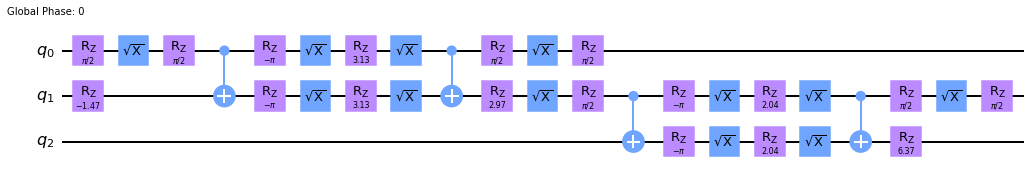

In [3]:
# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

In [4]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[0.9999921798 - 0.0039547854*I,                             0,                              0,                             0,                              0,                              0,                              0,                             0],
[                            0, 0.9999525415 - 0.0039546286*I, -0.0008497033 + 0.0088630496*I,                             0,                              0,                              0,                              0,                             0],
[                            0, 0.0007108045 + 0.0039546286*I,  0.4498730503 - 0.0353008317*I,                             0, -0.8923785578 + 0.0035291933*I,                              0,                              0,                             0],
[                            0,                             0,                              0, 0.4498908833 - 0.0353022311*I,                              0, -0.8923431851 + 0.0035290534*I,   0.000758263 - 0.0079092573*I,        

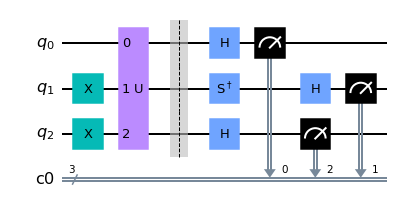

In [5]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [6]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [7]:
cal_circ[0].draw()

░ ┌─┐      
q34_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q34_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q34_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c1: 3/════╩══╩══╩═
           0  1  2

In [8]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [48]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [49]:
calib_circuits_identity[1].draw()

┌────┐┌───┐   ┌─┐
q2632_0: ┤0   ├┤ X ├───┤M├
         │    │└┬─┬┘   └╥┘
q2632_1: ┤1 U ├─┤M├─────╫─
         │    │ └╥┘ ┌─┐ ║ 
q2632_2: ┤2   ├──╫──┤M├─╫─
         └────┘  ║  └╥┘ ║ 
  c54: 3/════════╩═══╩══╩═
                 1   2  0

In [50]:
calib_circuits_itself[1].draw()

┌───┐┌────┐┌─┐      
q2631_0: ┤ X ├┤0   ├┤M├──────
         └───┘│    │└╥┘┌─┐   
q2631_1: ─────┤1 U ├─╫─┤M├───
              │    │ ║ └╥┘┌─┐
q2631_2: ─────┤2   ├─╫──╫─┤M├
              └────┘ ║  ║ └╥┘
  c53: 3/════════════╩══╩══╩═
                     0  1  2

In [51]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

In [52]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [53]:
Matrix(meas_fitter_qiskit.cal_matrix)

Matrix([
[0.95109375, 0.04990625,   0.035875, 0.00171875, 0.04346875,  0.0025625,      0.002,    6.25e-5],
[   0.01625,    0.91725, 0.00028125,  0.0331875, 0.00071875, 0.03996875,          0,   0.001625],
[ 0.0078125, 0.00059375,      0.925,   0.050375, 0.00034375,          0, 0.03940625,    0.00225],
[ 0.0001875, 0.00746875, 0.01490625, 0.89140625,   3.125e-5, 0.00028125, 0.00103125, 0.04090625],
[0.02378125,  0.0013125,    0.00075,   3.125e-5, 0.93184375,   0.048125,    0.03375,   0.001875],
[  0.000625, 0.02334375,    6.25e-5,  0.0008125,  0.0155625,   0.901125, 0.00053125,   0.034125],
[   0.00025,          0,   0.022625, 0.00171875, 0.00778125,   0.000375, 0.90634375, 0.04528125],
[         0,   0.000125,     0.0005,    0.02075,    0.00025,  0.0075625,  0.0169375,   0.873875]])

In [54]:
Matrix(meas_fitter_our_identity.cal_matrix)

Matrix([
[0.92115625,  0.0623125,     0.0405,   0.003875, 0.04578125,  0.0050625,   0.004125, 0.00028125],
[0.03028125, 0.88871875, 0.00196875, 0.03759375, 0.00309375, 0.04328125, 0.00021875, 0.00440625],
[ 0.0128125,  0.0014375,  0.8965625,  0.0623125, 0.00303125,  0.0004375,  0.0440625,  0.0051875],
[ 0.0010625, 0.01303125,   0.027125,  0.8626875,   0.000125, 0.00240625, 0.00328125, 0.04271875],
[0.02959375, 0.00378125, 0.00328125, 0.00034375,  0.9064375, 0.06121875, 0.03871875,      0.004],
[0.00228125, 0.02790625, 0.00021875,  0.0035625,  0.0273125,   0.874125, 0.00178125, 0.03690625],
[  0.002625, 0.00040625, 0.02771875, 0.00384375,  0.0133125, 0.00128125, 0.87940625, 0.06221875],
[ 0.0001875, 0.00240625,   0.002625, 0.02578125, 0.00090625,  0.0121875, 0.02840625, 0.84428125]])

In [16]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [17]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [18]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q1172_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q1172_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q1172_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
  c18: 3/══════╩════════════════╩══╩═
               1                0  2

In [19]:
meas_fitter_qiskit.cal_matrix

array([[9.5128125e-01, 4.9125000e-02, 3.5187500e-02, 1.4687500e-03,
        4.2343750e-02, 2.1250000e-03, 1.2187500e-03, 3.1250000e-05],
       [1.6656250e-02, 9.1690625e-01, 3.7500000e-04, 3.4656250e-02,
        9.6875000e-04, 4.0000000e-02, 0.0000000e+00, 1.2812500e-03],
       [8.1250000e-03, 2.1875000e-04, 9.2503125e-01, 4.9437500e-02,
        4.3750000e-04, 0.0000000e+00, 4.0687500e-02, 1.8125000e-03],
       [0.0000000e+00, 7.9687500e-03, 1.5406250e-02, 8.9009375e-01,
        0.0000000e+00, 3.4375000e-04, 5.0000000e-04, 3.8843750e-02],
       [2.3375000e-02, 1.2187500e-03, 8.4375000e-04, 6.2500000e-05,
        9.3328125e-01, 4.9531250e-02, 3.3906250e-02, 1.6875000e-03],
       [3.7500000e-04, 2.4343750e-02, 3.1250000e-05, 7.8125000e-04,
        1.4906250e-02, 9.0056250e-01, 6.5625000e-04, 3.4875000e-02],
       [1.8750000e-04, 0.0000000e+00, 2.2812500e-02, 9.6875000e-04,
        7.8437500e-03, 5.0000000e-04, 9.0859375e-01, 4.6843750e-02],
       [0.0000000e+00, 2.1875000e-04, 3.1

In [20]:


n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

cal_circ[0].draw()
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A


C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))





In [21]:



n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

cal_circ[0].draw()
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A


C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))





from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [22]:



n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

cal_circ[0].draw()
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A


C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))





from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [23]:



n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

cal_circ[0].draw()
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A


C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))





from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

raw_res.get_counts(-1)

{'011': 113,
 '111': 893,
 '101': 56,
 '000': 122,
 '010': 1562,
 '001': 14,
 '100': 1292,
 '110': 27948}

In [24]:



n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

cal_circ[0].draw()
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A


C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))





from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

raw_res.get_counts(-1)

for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [25]:



n_steps=51
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

cal_circ[0].draw()
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A


C_matrices_itself = []
C_matrices_identity = []

C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
C_identity = U_tilde_identity

for base in qcs_basis:
    
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))





from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

raw_res.get_counts(-1)

for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

itself_res.get_counts(-1)

{'000': 6.557077361006407e-10,
 '100': 1.811984311076223e-09,
 '101': 1.8407541674736114e-10,
 '110': 31999.999999997523,
 '111': 9.072510385099361e-10}

In [26]:
identity_res.get_counts(-1)

{'000': 2.6074544486914264e-11,
 '001': 4.30767029067845e-13,
 '010': 128.87302609069673,
 '011': 8.82842606388628,
 '100': 23.089527588879186,
 '101': 6.277067632292315e-12,
 '110': 31839.20902025649,
 '111': 2.7422348485663702e-11}

In [1]:
import matplotlib.pyplot as plt

In [12]:
PUNTI=60

F_raw=np.zeros(PUNTI)
F_Qiskit=np.zeros(PUNTI)
F_Identity=np.zeros(PUNTI)
F_circuit=np.zeros(PUNTI)



for m in range(PUNTI):
    n_steps=99
    time=np.pi*(m+0.001)/PUNTI
    #initial_state={"110": 1}
    shots = 8192
    backend = backend_sim_jakarta

    X = np.array([[0,1],[1,0]])  #defining the pauli matrices
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    Id = np.eye(2)

    # defining the hamiltonian divided in: 
    #       - H1: first two qubits interactions.
    #       - H2: second two qubits interactions.

    H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
    H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

    # building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

    trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
    trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
    Matrix(trotterized).n(3, chop=True)

    # phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

    A0 = trotterized[3, 6]
    A1 = trotterized[5, 6]
    A2 = trotterized[6, 6]

    r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
    r2=0
    f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
    f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
    a1=float(acos(abs(A2)))
    a2=float(acos(abs(A1)/sin(a1)))

    M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
    M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

    qr_U = QuantumRegister(3 ,name="q")
    qc_U = QuantumCircuit(qr_U, name="U")

    qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
    qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

    qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
    qc_U.draw(output="mpl")

    U_ideal=matrix_from_circuit(qc_U, type="numpy")
    Matrix(U_ideal)

    qr_evo = QuantumRegister(3, name="q")
    qc_evo = QuantumCircuit(qr_evo, name="U")

    qc_evo.x([qr_evo[1],qr_evo[2]])
    qc_evo.append(qc_U, qr_evo)

    qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
    qcs_tomo[3].draw(output="mpl")

    qr_cal = QuantumRegister(3)
    cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

    cal_circ[0].draw()
    calib_circuits_identity = []
    calib_circuits_itself = []

    for i in state_labels:

        cr_cal_itself = ClassicalRegister(3)
        qr_cal_itself = QuantumRegister(3)
        qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

        cr_cal_id = ClassicalRegister(3)
        qr_cal_id = QuantumRegister(3)
        qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

        qc_cal_id.append(qc_U, qr_cal_id)

        for k in range(3):
            if i[::-1][k] == "1":
                qc_cal_itself.x(qr_cal_itself[k])
                qc_cal_id.x(qr_cal_id[k])
            
        qc_cal_itself.append(qc_U, qr_cal_itself)
        
        qc_cal_id.measure(qr_cal_id, cr_cal_id)
        qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

        calib_circuits_identity.append(qc_cal_id)
        calib_circuits_itself.append(qc_cal_itself)

    job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

    job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

    job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[1,3,5])

    job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

    meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
    meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
    meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

    U_tilde_identity=meas_fitter_our_identity.cal_matrix
    U_tilde_itself=meas_fitter_our_itself.cal_matrix
    U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

    def matrix_from_cirquit(qc, phase=0, type="sympy"):

        backend = Aer.get_backend('unitary_simulator')
        job = execute(qc, backend, shots=32000)
        result = job.result()
        A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
        if type=="sympy":
            return Matrix(A)
        else:
            return A

    qr_basi = QuantumRegister(3)
    qc_basi = QuantumCircuit(qr_basi)

    qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

    qcs_basis[0].remove_final_measurements()

    qcs_basis[16].draw()


    C_matrices_itself = []
    C_matrices_identity = []

    C_itself = np.matmul(U_tilde_itself, np.linalg.inv(U_ideal))
    C_identity = U_tilde_identity

    for base in qcs_basis:
        
        base.remove_final_measurements()

        base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
        base_matrix_H = base_matrix.getH()

        C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), U_tilde_itself, np.linalg.inv(U_ideal),  base_matrix_H])
        #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
        C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_H))

        C_matrices_identity.append(np.asarray(C_aus_identity))
        C_matrices_itself.append(np.asarray(C_aus_itself))





    from copy import deepcopy

    meas_fitters_identity = []
    meas_fitters_itself = []

    for C_new in C_matrices_identity:
        meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
        meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

        meas_fitters_identity.append(meas_fitter_our_aus)

    for C_new in C_matrices_itself:
        meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
        meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

        meas_fitters_itself.append(meas_fitter_our_aus)

    target_state = (One^One^Zero).to_matrix()
    #target_state = (Zero^One^One).to_matrix()


    fids=np.zeros(4)

    raw_res=deepcopy(job_tomo.result())
    qiskit_res=deepcopy(raw_res)
    identity_res=deepcopy(raw_res)
    itself_res=deepcopy(raw_res)

    print(raw_res.get_counts(-1))

    for i in range(27):

        old_counts=raw_res.get_counts(i)
        new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
        qiskit_res.results[i].data.counts = new_counts_qiskit

        new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
        identity_res.results[i].data.counts = new_counts_id

        new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
        itself_res.results[i].data.counts = new_counts_it

    fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
    fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
    fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
    fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)


    F_raw[m]=fids[0] 
    F_Qiskit[m]=fids[1]
    F_Identity[m]=fids[2]
    F_circuit[m]=fids[3]

    print(fids[0]) 

    print(m)




{'110': 7097, '010': 360, '111': 251, '000': 34, '100': 408, '101': 26, '011': 12, '001': 4}
0.8700049684832093
0
{'110': 7029, '010': 371, '111': 256, '101': 115, '100': 362, '001': 5, '000': 43, '011': 11}
0.8626010572745634
1
{'110': 6811, '100': 364, '111': 231, '010': 368, '101': 355, '000': 41, '001': 10, '011': 12}
0.8349132011808665
2
{'110': 6488, '101': 703, '010': 292, '111': 229, '001': 39, '100': 377, '000': 33, '011': 31}
0.7905515682610893
3
{'110': 6042, '100': 392, '101': 1079, '010': 301, '111': 216, '001': 62, '000': 41, '011': 59}
0.7327263114396959
4
{'110': 5525, '101': 1556, '111': 234, '100': 364, '010': 239, '000': 41, '001': 97, '011': 136}
0.6682811476062939
5
{'101': 2073, '110': 4878, '010': 248, '100': 407, '011': 249, '001': 99, '111': 209, '000': 29}
0.5906526391857998
6
{'111': 208, '100': 376, '110': 4143, '011': 453, '101': 2574, '010': 259, '000': 31, '001': 148}
0.5157088579549385
7
{'101': 2918, '011': 666, '110': 3611, '001': 169, '111': 216, '100

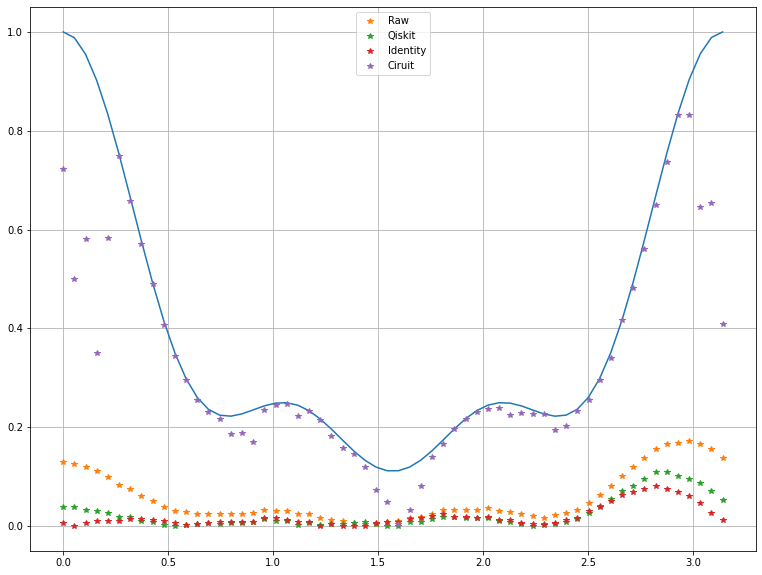

In [25]:
t=np.linspace(0+0.001,np.pi,PUNTI)
plt.figure(figsize=(13,10))

plt.plot(ts, probs_110)
plt.plot(t,np.abs(F_raw-probs_110),linestyle='',marker='*',label='Raw')
plt.plot(t,np.abs(F_Qiskit-probs_110),linestyle='',marker='*',label='Qiskit')
plt.plot(t,np.abs(F_Identity-probs_110),linestyle='',marker='*',label='Identity')
plt.plot(t,np.abs(F_circuit-probs_110),linestyle='',marker='*',label='Ciruit')
plt.legend()
plt.grid()
plt.show()


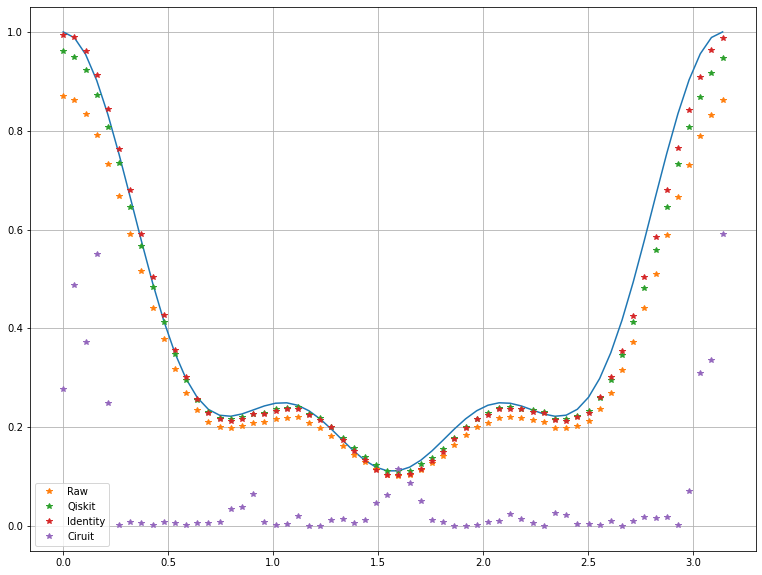

In [26]:
t=np.linspace(0+0.001,np.pi,PUNTI)
plt.figure(figsize=(13,10))

plt.plot(ts, probs_110)
plt.plot(t,np.abs(F_raw),linestyle='',marker='*',label='Raw')
plt.plot(t,np.abs(F_Qiskit),linestyle='',marker='*',label='Qiskit')
plt.plot(t,np.abs(F_Identity),linestyle='',marker='*',label='Identity')
plt.plot(t,np.abs(F_circuit),linestyle='',marker='*',label='Ciruit')
plt.legend()
plt.grid()
plt.show()

In [14]:
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [15]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

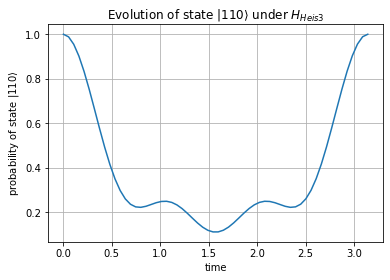

In [20]:
from qiskit.opflow import Zero, One, I, X, Y, Z
# Define array of time points
ts = np.linspace(0+0.001, np.pi, PUNTI)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()